# Anomalous Difference Map  

In [Basics](1_basics.ipynb), we loaded a room-temperature dataset that was collected at ~6550 eV of tetragonal HEWL. We then computed the $CC_{1/2}$ and $CC_{anom}$ for this data in [Merging Statistics](2_mergingstats.ipynb) and observed that there was significant anomalous signal. Let's now use that data to generate an anomalous difference map based on the anomalous scattering from the native sulfur atoms.

In [1]:
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
import numpy as np

In [2]:
print(rs.__version__)

0.9.4


In [3]:
# Load data and extract relevant columns
refltable = rs.read_mtz("data/HEWL_SSAD_24IDC.mtz")
refltable = refltable[["I(+)", "SIGI(+)", "I(-)", "SIGI(-)", "N(+)", "N(-)"]]
refltable.head()

I(+)    SIGI(+)      I(-)    SIGI(-)  N(+)  N(-)
H K L                                                       
0 0 4  661.29987  21.953098 661.29987  21.953098    16    16
    8   3229.649 105.980934  3229.649 105.980934    16    16
    12 1361.8672   43.06085 1361.8672   43.06085    16    16
    16  4124.393  196.89108  4124.393  196.89108     8     8
1 0 1  559.33685     8.6263 559.33685     8.6263    64    64

In [4]:
print(f"Number of reflections: {len(refltable)}")

Number of reflections: 12542


---
### Background

Since this dataset was collected at a single wavelength, we can compute an anomalous difference map from the anomalous structure factor amplitudes, $|F_{A}|$, and their phase shifts, $\alpha$, relative to the computed phases from an isomorphous structure of tetragonal HEWL. We will compute $|F_{A}|$ based on the following:

\begin{equation*}
|F_{A}| \propto \Delta_{\mathrm{ano}} = |F_{HKL}| - |F_{\overline{HKL}}|
\end{equation*}

We will then use a model refined from this data to obtain the phases, $\phi_c$, which can be used to determine the phases for the anomalous contribution, $\phi_A$, using the phase shift, $\alpha$:

\begin{equation*}
\phi_A = \phi_c - \alpha
\end{equation*}

Since this is a SAD experiment, we can assume $\alpha$ is 90˚ when $\Delta_{\mathrm{ano}}$ is negative and 270˚ when it is positive. This formalism is based on [Thorn and Sheldrick, J Appl. Cryst. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3246834/pdf/j-44-01285.pdf).

---
### Computing Structure Factor Amplitudes

The dataset being used is the direct output from running scaling and merging in [AIMLESS](http://www.ccp4.ac.uk/html/aimless.html). As a first processing step, we need to convert the observed merged intensities, $I(+)$ and $I(-)$, into observed structure factor amplitudes, $F(+)$ and $F(-)$.

In [5]:
# Stack intensities from 2-column anomalous to 1-column format
stacked = refltable.stack_anomalous()
stacked = stacked.loc[stacked["N"] > 0]
stacked.sort_index(inplace=True)
stacked.head()

I      SIGI  N
H   K   L                         
-45 -10 -1   6.185645  2.932488  4
    -9  -2  27.028767 3.8457258  4
        -1  3.0018542 2.6649861  4
    -8  -3 -0.9806365 2.7741797  4
        -2  12.085027 3.0270035  4

In order to get structure factor amplitudes, we must first account for mean intensities that are negative due to background subtraction. We will use a method based on the Bayesian approach first proposed by [French and Wilson](https://scripts.iucr.org/cgi-bin/paper?a15572) to ensure that all intensities are strictly positive. This method is implemented in `rs.algorithms.scale_merged_intensities()`.

In [6]:
scaled = rs.algorithms.scale_merged_intensities(stacked, "I", "SIGI", 
                                                mean_intensity_method="anisotropic")

In [7]:
scaled.head()

I      SIGI  N      dHKL  CENTRIC      FW-I   FW-SIGI  \
H   K   L                                                                   
-45 -10 -1   6.185645  2.932488  4 1.7194303    False 6.1471047 2.7739754   
    -9  -2  27.028767 3.8457258  4 1.7217723    False 26.716537 3.8457258   
        -1  3.0018542 2.6649861  4  1.727153    False 3.5474997 2.1485696   
    -8  -3 -0.9806365 2.7741797  4 1.7197415    False 1.8468517 1.4775624   
        -2  12.085027 3.0270035  4 1.7287054    False 11.893286   3.02595   

                FW-F    FW-SIGF  
H   K   L                        
-45 -10 -1 2.4032679  0.6094333  
    -9  -2 5.1551414 0.37557602  
        -1 1.7800175  0.6156602  
    -8  -3 1.2411455  0.5535428  
        -2 3.4186602 0.45392564

French-Wilson scaling leaves large intensities relatively unchanged, but rescales negative and small intensities to be positive by imposing Wilson's distribution as a prior:

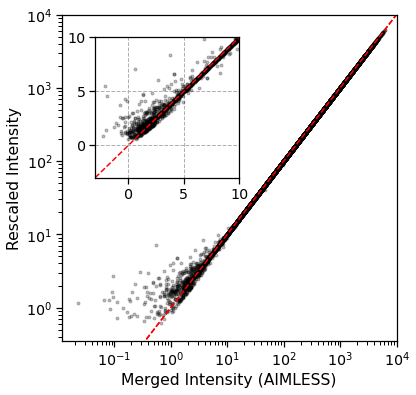

In [8]:
x = np.linspace(-3, 10000, 2)
plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.plot(x, x, '--r', scalex=False, scaley=True)
plt.plot(scaled["I"], scaled["FW-I"], "k.", alpha=0.25)
plt.plot(plt.xlim(), plt.xlim(), '--r', scalex=False, scaley=True)
plt.xlabel("Merged Intensity (AIMLESS)")
plt.ylabel("Rescaled Intensity")
plt.xscale("log")
plt.yscale("log")
plt.xlim(right=1e4)
plt.ylim(top=1e4)

# Inset
axins = ax.inset_axes([0.1, 0.5, 0.43, 0.43])
axins.plot(scaled["I"], scaled["FW-I"], "k.", alpha=0.25)
axins.plot(x, x, '--r')
axins.set_xlim(-3, 10)
axins.set_ylim(-3, 10)
axins.grid(linestyle="--")

plt.show()

In [9]:
# Remove extra columns
scaled = scaled[["FW-F", "FW-SIGF", "N"]]

# "Unstack" anomalous data from one-column to two-column format
anom = scaled.unstack_anomalous(["FW-F", "FW-SIGF", "N"]).dropna()

In [10]:
anom.head()

FW-F(+)  FW-SIGF(+)  N(+)   FW-F(-)  FW-SIGF(-)  N(-)
H K L                                                         
0 0 4    25.7036   0.4273095    16   25.7036   0.4273095    16
    8  56.794975  0.93358195    16 56.794975  0.93358195    16
    12 36.885887   0.5840336    16 36.885887   0.5840336    16
    16  64.02966   1.5395098     8  64.02966   1.5395098     8
1 0 1  23.647089  0.18242109    64 23.647089  0.18242109    64

In [11]:
# Compute differences
dF    = np.abs(anom["FW-F(+)"] - anom["FW-F(-)"])
sigDF = np.sqrt(anom["FW-SIGF(+)"]**2 + anom["FW-SIGF(-)"]**2)
anom["ANOM"] = rs.DataSeries(dF, dtype="SFAmplitude")
anom["SigANOM"] = rs.DataSeries(sigDF, dtype="Stddev")

In [12]:
anom.head()

FW-F(+)  FW-SIGF(+)  N(+)   FW-F(-)  FW-SIGF(-)  N(-)  ANOM  \
H K L                                                                  
0 0 4    25.7036   0.4273095    16   25.7036   0.4273095    16   0.0   
    8  56.794975  0.93358195    16 56.794975  0.93358195    16   0.0   
    12 36.885887   0.5840336    16 36.885887   0.5840336    16   0.0   
    16  64.02966   1.5395098     8  64.02966   1.5395098     8   0.0   
1 0 1  23.647089  0.18242109    64 23.647089  0.18242109    64   0.0   

          SigANOM  
H K L              
0 0 4  0.60430694  
    8   1.3202842  
    12 0.82594824  
    16  2.1771955  
1 0 1  0.25798237

---
### Phasing the Anomalous Difference Map

Below, we will compute the necessary phase shifts to go from the phases of a $2 F_o - F_c$ map to the phases associated with the anomalous difference structure factors. Although this model was refined to this data in PHENIX, the phases from any isomorphous structure could have been used to obtain a reasonable map. 

In [13]:
ref = rs.read_mtz("data/HEWL_refined.mtz")

In [14]:
# Find common HKL indices
hkls = anom.index.intersection(ref.index).sort_values()
anom = anom.loc[hkls]

As mentioned in [Background](4_anomalousmap.ipynb#Background), we can compute the anomalous phases as follows:

\begin{equation*}
\phi_A = \phi_c - \alpha
\end{equation*}

where $\alpha$ is 90˚ when $\Delta_{\mathrm{ano}}$ is negative and 270˚ when it is positive.

In [15]:
alpha = 90 + 180*(anom["FW-F(+)"] >= anom["FW-F(-)"])
anom["PHANOM"] = ref.loc[hkls, "PH2FOFCWT"] + alpha
anom["PHANOM"] = rs.utils.canonicalize_phases(anom["PHANOM"].astype("Phase"))

### Viewing the Map  

Since we have structure factor amplitudes, `anom["ANOM"]`, and phases, `anom["PHANOM"]`, for the anomalous structure factors, we can now view the anomalous difference map. This can be done by writing out an MTZ file, and loading it into COOT, PyMOL, or any other molecular graphics package. 

In [16]:
anom.dtypes

FW-F(+)       FriedelSFAmplitude
FW-SIGF(+)       StddevFriedelSF
N(+)                      MTZInt
FW-F(-)       FriedelSFAmplitude
FW-SIGF(-)       StddevFriedelSF
N(-)                      MTZInt
ANOM                 SFAmplitude
SigANOM                   Stddev
PHANOM                     Phase
dtype: object

In [17]:
anom.write_mtz("data/anomdiff.mtz")

Looking at the anomalous difference map on the refined structure, we can see positive difference density on all of the sulfurs in HEWL (shown below in purple):

In [18]:
%%html
<center>
    <iframe src="https://hekstra-lab.github.io/reciprocalspaceship/data/anomdiff/anomdiff.html#zoom=25", width=600, height=600></iframe>
    <br>Anomalous difference map from HEWL crystal overlayed with refined model (PDB: 7L84). Map is contoured at +5&sigma;.
</center>